# Regression Forest

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import concurrent.futures
import train_forest as tf
import assess_forest as af
import seaborn as sns

%matplotlib inline

In [3]:
%store -r x_train x_val x_test y_train y_val y_test

In [4]:
x_train = pd.DataFrame(x_train)
x_val = pd.DataFrame(x_val)
x_test = pd.DataFrame(x_test)

y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

# Train a Random Forest

In [5]:
def train_forest(x, y, max_depth, feature_frac, num_trees, min_leaf_size):
    trees = []
    with concurrent.futures.ProcessPoolExecutor() as executor: 
        for i in range(num_trees):
            x_bagg = x.reset_index(drop=True)
            x_bagg = x_bagg.sample(frac=1, replace=True)
            y_bagg = y[x_bagg.index.to_numpy()]
            trees.append(executor.submit(tf.split_forest, x_bagg ,y_bagg, max_depth, feature_frac, min_leaf_size))
    rules_forest = [tree.result() for tree in trees]
    return rules_forest

def train_forest_f(x, y, max_depth, feature_frac, num_trees, min_leaf_size):
    trees = []
    
    with concurrent.futures.ProcessPoolExecutor() as executor: 
        for i in range(num_trees):
            
            x_bagg = x.reset_index(drop=True)
            x_bagg = x_bagg.sample(frac=1, replace=True)
            y_bagg = y[x_bagg.index.to_numpy()]
            
            feats_sampled = x_bagg.shape[1] // feature_frac
            cols_sampled = random.sample(list(x_bagg.columns), feats_sampled)
            
            trees.append(executor.submit(tf.split_forest_f, x_bagg[cols_sampled] ,y_bagg, max_depth, min_leaf_size))
            
    rules_forest = [tree.result() for tree in trees]
    return rules_forest


def predict_forest(x, rules):

    y_pred = np.empty((len(x), len(rules)))
    
    with concurrent.futures.ProcessPoolExecutor() as executor: 
        preds = [executor.submit(af.pred_x, x, rule) for rule in rules]
        for ix, val in enumerate(preds):
            y_pred[:,ix] = val.result()

    return y_pred.mean(axis=1)


def predict_forests(x, forests):

    predictions = []
    
    for rules in forests:
        y_pred = np.empty((len(x), len(rules)))
        with concurrent.futures.ProcessPoolExecutor() as executor: 
            preds = [executor.submit(af.pred_x, x, rule) for rule in rules]
            for ix, val in enumerate(preds):
                y_pred[:,ix] = val.result()
                prediction = y_pred.mean(axis=1)
        predictions.append(prediction)
    return predictions



def return_rmse(x, y, rules):

    y_pred = np.empty((len(x), len(rules)))
    
    with concurrent.futures.ProcessPoolExecutor() as executor: 
        preds = [executor.submit(af.pred_x, x, rule) for rule in rules]
        for ix, val in enumerate(preds):
            y_pred[:,ix] = val.result()

    pred = y_pred.mean(axis=1)
    mse = np.mean(np.square(pred - y))
    return np.sqrt(mse)



# Tune Hyperparameters via Random Search

Tune tree depth, feature split and min leaf size:

In [31]:
num_iterations = 30
tree_depths = np.random.randint(5,30,num_iterations)
feature_splits = np.random.randint(2,6,num_iterations)
num_trees = np.random.randint(10,100,num_iterations)
min_leaf_sizes = np.random.randint(2,40,num_iterations)

best_forest = None
best_rmse = np.inf

rmse_preds = []
rmse_trains = []


for i in range(num_iterations):
    
    print(f"Running iteration {i+1} of {num_iterations}")
    
    forest = train_forest(x_train, y_train, max_depth = tree_depths[i], feature_frac = feature_splits[i], num_trees =num_trees[i] , min_leaf_size = min_leaf_sizes[i])
    error_pred = return_rmse(x_val,y_val,forest)
    error_train = return_rmse(x_train,y_train,forest)
    
    rmse_preds.append(error_pred)
    rmse_trains.append(error_train)
    
    if error_pred < best_rmse:
        best_rmse = error_pred
        best_forest = forest
        

Running iteration 1 of 30
Running iteration 2 of 30
Running iteration 3 of 30
Running iteration 4 of 30
Running iteration 5 of 30
Running iteration 6 of 30
Running iteration 7 of 30
Running iteration 8 of 30
Running iteration 9 of 30
Running iteration 10 of 30
Running iteration 11 of 30
Running iteration 12 of 30
Running iteration 13 of 30
Running iteration 14 of 30
Running iteration 15 of 30
Running iteration 16 of 30
Running iteration 17 of 30
Running iteration 18 of 30
Running iteration 19 of 30
Running iteration 20 of 30
Running iteration 21 of 30
Running iteration 22 of 30
Running iteration 23 of 30
Running iteration 24 of 30
Running iteration 25 of 30
Running iteration 26 of 30
Running iteration 27 of 30
Running iteration 28 of 30
Running iteration 29 of 30
Running iteration 30 of 30


In [36]:
forest_tuning_final = zip(tree_depths,feature_splits,num_trees,min_leaf_sizes,rmse_trains,rmse_preds)
best_forest_final = best_forest

In [37]:
%store forest_tuning_final best_forest_final

Stored 'forest_tuning_final' (zip)
Stored 'best_forest_final' (list)


In [38]:
%store -r forest_tuning_final best_forest_final

In [41]:
tree_depths,feature_splits,num_trees,min_leaf_sizes,rmse_trains,rmse_preds = zip(*forest_tuning_final)

ValueError: not enough values to unpack (expected 6, got 0)

In [13]:
bix = rmse_preds.index(best_rmse)
btd = tree_depths[bix]
bfs = feature_splits[bix]
bnt = num_trees[bix]
bmls = min_leaf_sizes[bix]

In [44]:
error_test = return_rmse(x_test,y_test,best_forest_final)

In [45]:
error_test

1.9302120365383264

In [46]:
forest_maes = abs(predict_forest(x_test,best_forest_final)-y_test)
%store forest_maes

Stored 'forest_maes' (ndarray)


# HP Tuning Visualisation

In [97]:
nt = np.array(num_trees)
td = np.array(tree_depths)
fs = np.array(feature_splits)
ls = np.array(min_leaf_sizes)
rp = np.array(rmse_preds)
rt = np.array(rmse_trains)

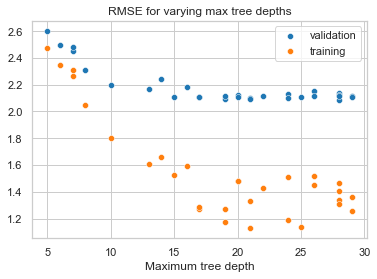

In [174]:
sns.scatterplot(x=td,y=rp,label='validation')
sns.scatterplot(x=td,y=rt,label='training')
plt.title('RMSE for varying max tree depths')
plt.xlabel('Maximum tree depth')
plt.savefig('figures\\rfhp1.png')
plt.show()


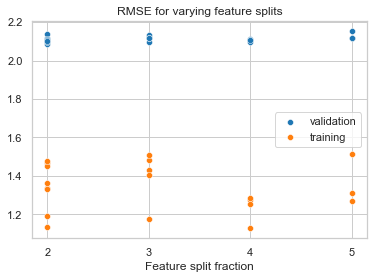

In [176]:
sns.scatterplot(x=fs[td>=17], y=rp[td>=17],label='validation')
sns.scatterplot(x=fs[td>=17], y=rt[td>=17],label='training')
plt.title('RMSE for varying feature splits')
plt.xlabel('Feature split fraction')
plt.xticks([2,3,4,5])
plt.savefig('figures\\rfhp2.png')
plt.show()

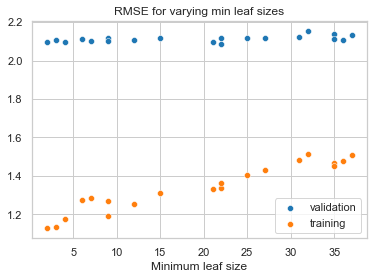

In [184]:
sns.scatterplot(x=ls[td>=17], y=rp[td>=17],label='validation')
sns.scatterplot(x=ls[td>=17], y=rt[td>=17],label='training')
plt.title('RMSE for varying min leaf sizes')
plt.xlabel('Minimum leaf size')
#plt.savefig('figures\\rfhp3.png')
plt.show()

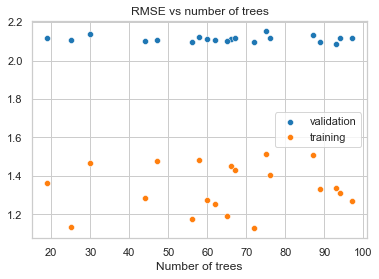

In [178]:
sns.scatterplot(x=nt[td>=17], y=rp[td>=17],label='validation')
sns.scatterplot(x=nt[td>=17], y=rt[td>=17],label='training')
plt.title('RMSE vs number of trees')
plt.xlabel('Number of trees')
plt.savefig('figures\\rfhp4.png')
plt.show()

# Toy Problem

In [30]:
%store -r x_toy_train y_toy_train x_toy_test y_toy_test

In [31]:
forest_toy = train_forest(pd.DataFrame(x_toy_train), y_toy_train, max_depth = btd, feature_frac = bfs, num_trees = bnt , min_leaf_size = bmls)

In [32]:
y_pred_toy = predict_forest(pd.DataFrame(x_toy_test),forest_toy)

In [33]:
ae_toy = abs(y_pred_toy - y_toy_test)
mae_toy = ae_toy.mean()
mse_toy = (np.square(ae_toy).sum())/y_pred_toy.shape[0]
rmse_toy = np.sqrt(mse_toy)
print(f"RMSE for the toy problem = {rmse_toy:.04f}")

RMSE for the toy problem = 0.1275


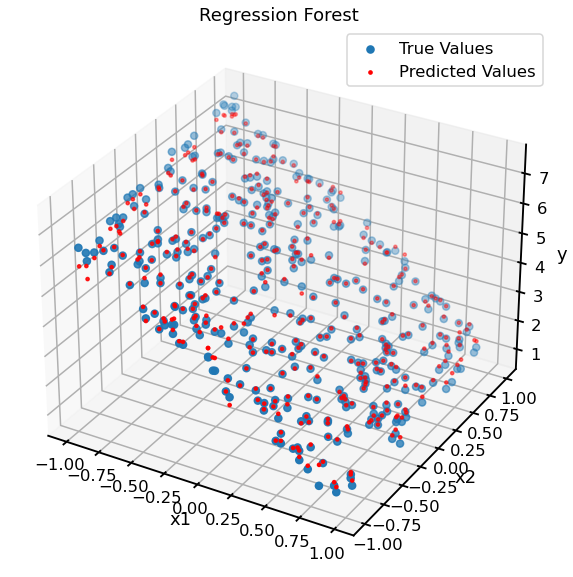

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context("talk")
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(x_toy_test[:,0], x_toy_test[:,1], y_toy_test, s=50,label='True Values')
ax.scatter(x_toy_test[:,0], x_toy_test[:,1], y_pred_toy, color='r',s=10,label='Predicted Values')
plt.legend()
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Regression Forest")
plt.savefig("figures\\rftoy.png")
plt.show()